# RQ3: Detect using custom DL models

In [30]:
from google import genai
from google.genai import types
import os
import numpy as np
import pandas as pd
import configparser
from tqdm import tqdm
import ast
import time
from vertexai.preview import tokenization

random_seed = 42

In [12]:
class GeminiEmbeddingGenerator:
    def __init__(self, model_name, embedding_type):
        self.model_name = model_name
        self.embedding_type = embedding_type
        self.__setup()

    def __setup(self):
        config = configparser.ConfigParser()
        config.read(".config")
        GEMINI_API_KEY = config["API_KEYS"]["GEMINI_API_KEY"]

        self.__client = genai.Client(api_key=GEMINI_API_KEY)
        self.__tokenizer = tokenization.get_tokenizer_for_model("gemini-1.5-flash-001")
    
    def get_token_count(self, text):
        return self.__tokenizer.count_tokens(text).total_tokens 

    def get_embeddings(self, text):
        #return np.arange(1,768,1).tolist()
        result = self.__client.models.embed_content(
                        model=self.model_name ,
                        contents=text,
                        config=types.EmbedContentConfig(task_type=self.embedding_type)
                )
        return result.embeddings[0].values

## Simple classificaton task using LLM embeddings

In [13]:
os.makedirs("./Results/RQ3/Model1", exist_ok=True)

In [14]:
df = pd.read_csv("./data/Complete_GoldSet.csv")
df['text'] = "CommitMessage: " + df['CommitMessage'] + "\nDiff:\n" +  df['Diff']

In [15]:
egen = GeminiEmbeddingGenerator("text-embedding-004", "CLASSIFICATION")
id = []
X = []
Y = []

In [7]:
for _, row in tqdm(df.iterrows()):
    emb = egen.get_embeddings(row['text'])
    id.append(row["CommitHash"])
    X.append(emb)
    Y.append(row["Decision"])
    time.sleep(0.25)

1764it [16:59,  1.73it/s]


In [8]:
df_emb = pd.DataFrame(data={"Hash": id, "Embeddings": X, "Label": Y})
df_emb['Embeddings'] = df_emb['Embeddings'].astype('object')
df_emb.to_csv("./data/Embeddings/MsgDiff.csv", index=False)

arr_x = np.array(X)
np.save("./data/Embeddings/MsgDiff.npy", arr_x)

In [27]:
df_emb = pd.read_csv("./data/Embeddings/MsgDiff.csv")
df_emb["Embeddings"] = df_emb["Embeddings"].apply(ast.literal_eval)

Accuracy: 0.8754
Precision: 0.8571
Recall: 0.9050
F1 Score: 0.8804
MCC Score: 0.7517

Classification Report:
               precision    recall  f1-score   support

       Buggy       0.86      0.91      0.88       179
    NotBuggy       0.90      0.84      0.87       174

    accuracy                           0.88       353
   macro avg       0.88      0.87      0.88       353
weighted avg       0.88      0.88      0.88       353



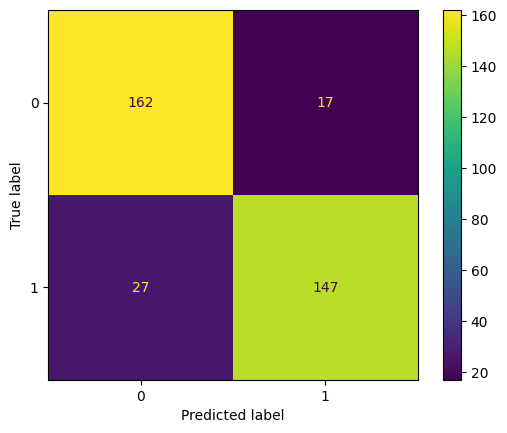

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC

# Load dataset

X = df_emb['Embeddings']
X = np.array([np.array(lst) for lst in X])

y = df_emb['Label'].values

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

# Initialize classifier
model = SVC(random_state=random_seed)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label="Buggy")
recall = recall_score(y_test, y_pred, pos_label="Buggy")
f1 = f1_score(y_test, y_pred, pos_label="Buggy")
mcc = matthews_corrcoef(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()


In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X = df_emb['Embeddings']
X = np.array([np.array(lst) for lst in X])

y = df_emb['Label'].values

# Define K-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

# Initialize classifier
model = SVC(random_state=random_seed)

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Perform cross-validation
cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)

# Print the results
for metric in scoring:
    metric_values = cv_results[f"test_{metric}"]
    print(f"{metric}: {metric_values.mean():.4f} ± {metric_values.std():.4f}")

accuracy: 0.8934 ± 0.0284
precision_macro: 0.8935 ± 0.0273
recall_macro: 0.8933 ± 0.0284
f1_macro: 0.8927 ± 0.0282


## Multi-step Classification

In [17]:
hashes = []
msg_cls_emb = []
msg_sim_emb = []
diff_sim_emb = []
labels = []
egen_cls = GeminiEmbeddingGenerator("text-embedding-004", "CLASSIFICATION")
egen_sim = GeminiEmbeddingGenerator("text-embedding-004", "SEMANTIC_SIMILARITY")

for _, row in tqdm(df.iterrows()):
    try:
        msg_cls_emb.append(egen_cls.get_embeddings(row['CommitMessage']))

        msg_sim_emb.append(egen_sim.get_embeddings(row['CommitMessage']))
        diff_sim_emb.append(egen_sim.get_embeddings(row['Diff']))

        hashes.append(row["CommitHash"])
        labels.append(row["Decision"])
        time.sleep(0.5)
    except Exception as e:
        print(e)
        time.sleep(30)

1764it [52:02,  1.77s/it]


In [18]:
df_emb = pd.DataFrame(data={"Hash": hashes, "Msg_Cls_Embeddings": msg_cls_emb, "Msg_Sim_Embeddings": msg_sim_emb, "Diff_Sim_Embeddings": diff_sim_emb, "Label": labels})
df_emb.to_csv("./data/Embeddings/MsgCls_MsgDiffSim.csv", index=False)

arr_x = np.array(msg_cls_emb)
np.save("./data/Embeddings/MsgCls.npy", arr_x)
arr_x = np.array(msg_sim_emb)
np.save("./data/Embeddings/MsgSim.npy", arr_x)
arr_x = np.array(diff_sim_emb)
np.save("./data/Embeddings/DiffSim.npy", arr_x)

In [58]:
df_emb = pd.read_csv("./data/Embeddings/MsgCls_MsgDiffSim.csv")
df_emb["Msg_Cls_Embeddings"] = df_emb["Msg_Cls_Embeddings"].apply(ast.literal_eval)
df_emb["Msg_Sim_Embeddings"] = df_emb["Msg_Sim_Embeddings"].apply(ast.literal_eval)
df_emb["Diff_Sim_Embeddings"] = df_emb["Diff_Sim_Embeddings"].apply(ast.literal_eval)

In [115]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, Model, Input
import numpy as np

input_shape = (768,)

# Commit Message Classification Model
input_a = Input(shape=input_shape, name="input_a")
x_a = layers.Dense(512, activation='relu')(input_a)
x_a = layers.Dense(64, activation='relu')(x_a)
x_a = layers.Dense(32, activation='relu')(x_a)
class_output = layers.Dense(1, activation='softmax', name="class_output")(x_a)


# Commit Message and Diff Similarity Model
input_b = Input(shape=input_shape, name="input_b")
input_c = Input(shape=input_shape, name="input_c")

def shared_siamese_network(input_layer):
    x = layers.Dense(64, activation='relu')(input_layer)
    x = layers.Dense(32, activation='relu')(x)
    output = layers.Dense(16, activation='linear')(x) 
    return output

embedding_b = shared_siamese_network(input_b)
embedding_c = shared_siamese_network(input_c)

def cosine_similarity(vectors):
    x, y = vectors
    x = tf.nn.l2_normalize(x, axis=1)  # Normalize vectors
    y = tf.nn.l2_normalize(y, axis=1)
    return tf.reduce_sum(x * y, axis=1, keepdims=True)  # Compute dot product (cosine similarity)

similarity_output = layers.Lambda(cosine_similarity, name="similarity_output")([embedding_b, embedding_c])

# Final Output
final_output = layers.Multiply()([class_output, similarity_output])
final_output = layers.Dense(1, activation='softmax', name="final_output")(final_output)


# Model
model = Model(inputs=[input_a, input_b, input_c], outputs=[class_output, similarity_output, final_output])


# Optimizers
optimizer_classification = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_similarity = tf.keras.optimizers.SGD(learning_rate=0.01)

optimizers_and_layers = [(tf.keras.optimizers.Adam(learning_rate=0.001), "class_output"),
                         (tf.keras.optimizers.SGD(learning_rate=0.01), "similarity_output"),
                         (tf.keras.optimizers.Adam(learning_rate=0.001), "final_output")]

# Losses
losses = {
    "class_output": "binary_crossentropy",
    "similarity_output": "mse",
    "final_output": "binary_crossentropy"
}

# Metrics
metrics = {
    "class_output": "accuracy",
    "similarity_output": "mae",
    "final_output": "accuracy"
}

# # Compile for classification
# model.compile(optimizer=optimizer_classification, loss={"class_output": "categorical_crossentropy"}, metrics={"class_output": "accuracy"})

# # Compile for similarity
# model.compile(optimizer=optimizer_similarity, loss={"similarity_output": "mse"}, metrics={"similarity_output": "mae"})

# # Compile for final output
# model.compile(optimizer=optimizer_classification, loss={"final_output": "binary_crossentropy"}, metrics={"final_output": "accuracy"})
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)
model.compile(
    optimizer=optimizer,
    loss=losses,
    metrics=metrics
)
# **Model Summary**
model.summary()


ModuleNotFoundError: No module named 'tensorflow_addons'

In [105]:
g = pd.read_csv("./data/GoldSet.csv")
tangled_buggy = df_emb[df_emb['Hash'].isin(g['CommitHash'])]
tangled_buggy["Similarity"] = tangled_buggy["Label"].apply(lambda x: 0 if x=="NotBuggy" else 1)

true_buggy_notbuggy = df_emb[~df_emb['Hash'].isin(g['CommitHash'])]
true_buggy_notbuggy["Similarity"] = 1

df_emb = pd.concat([tangled_buggy, true_buggy_notbuggy])

C:\Users\opuna\AppData\Local\Temp\ipykernel_13076\454152308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tangled_buggy["Similarity"] = tangled_buggy["Label"].apply(lambda x: 0 if x=="NotBuggy" else 1)
C:\Users\opuna\AppData\Local\Temp\ipykernel_13076\454152308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_buggy_notbuggy["Similarity"] = 1


In [106]:
input_data_a = np.array([np.array(lst) for lst in df_emb["Msg_Cls_Embeddings"].values])
input_data_b = np.array([np.array(lst) for lst in df_emb["Msg_Sim_Embeddings"].values])
input_data_c = np.array([np.array(lst) for lst in df_emb["Diff_Sim_Embeddings"].values])

class_labels = [0 if x=="NotBuggy" else 1 for x in df_emb["Label"].values]
similarity_labels = df_emb["Similarity"].values
final_labels = class_labels

In [107]:
input_data_a.shape, input_data_b.shape, input_data_c.shape, len(class_labels), len(similarity_labels), len(final_labels)

((1764, 768), (1764, 768), (1764, 768), 1764, 1764, 1764)

In [108]:
type(input_data_a), type(input_data_b), type(input_data_c), type(class_labels), type(similarity_labels), type(final_labels)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, list, numpy.ndarray, list)

In [109]:
input_data_a

array([[ 0.00349273, -0.02269206, -0.02703833, ..., -0.00041784,
         0.08692812,  0.00581245],
       [ 0.00349273, -0.02269206, -0.02703833, ..., -0.00041784,
         0.08692812,  0.00581245],
       [-0.00462745, -0.00393904, -0.03195553, ..., -0.04037669,
         0.03765075, -0.01375232],
       ...,
       [ 0.07172944, -0.02593247, -0.00532279, ...,  0.01402581,
         0.04155925, -0.06475929],
       [ 0.00668423, -0.01045763, -0.01049829, ..., -0.03779543,
         0.03245691,  0.00824588],
       [ 0.01470073, -0.07062585, -0.03694122, ...,  0.02055164,
         0.0662635 ,  0.00576166]], shape=(1764, 768))

In [100]:
np.array([i-1 for i in range(3000)], dtype=float)

array([-1.000e+00,  0.000e+00,  1.000e+00, ...,  2.996e+03,  2.997e+03,
        2.998e+03], shape=(3000,))

In [111]:
history = model.fit(
    [np.array(input_data_a), np.array(input_data_b), np.array(input_data_c)], 
    {
        "class_output": np.array(class_labels), 
        "similarity_output": np.array(similarity_labels), 
        "final_output": np.array(final_labels)
    }, 
    epochs=10, 
    batch_size=32
)


Epoch 1/10


d:\Winter 2025\COMP 7890 - Data-driven Software Engineering\Project\Tangled\.venv\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


ValueError: Expected keys ListWrapper(['class_output', 'similarity_output', 'final_output']) in loss dict, but found loss.keys()=['final_output']